# NLP Proof of Concept

## Importing Text Data

In [417]:
import requests
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span

In [418]:
url = "https://news-article-extraction.p.rapidapi.com/"

payload = {"url": "https://www.cnn.com/2022/07/05/us/highland-park-illinois-shooting-july-fourth-parade-tuesday-intl-hnk/index.html"}
headers = {
	"content-type": "application/json",
	"X-RapidAPI-Key": "5236642101msh96442d04a67a589p195175jsnc3f7e97f983e",
	"X-RapidAPI-Host": "news-article-extraction.p.rapidapi.com"
}

request = requests.request("POST", url, json=payload, headers=headers)

request_json = request.json()
request_json.keys()

dict_keys(['author', 'content', 'meta_description', 'og_title', 'publishedAt', 'raw_html_source', 'source_url', 'status_code', 'title', 'url', 'urlToImage'])

In [419]:
text = request_json['content']
text = text[30:]
print(text)

The suspect in Monday's mass shooting at a July 4th parade in Highland Park, Illinois, that left seven dead and injured more than two dozen has been charged with seven counts of first-degree murder, Lake County State's Attorney Eric Rinehart announced during a news conference Tuesday evening.

If Robert E. Crimo III , 21, is convicted, the charges could lead to a mandatory life sentence, Rinehart said. More charges are expected to come, Rinehart said, including attempted murder, aggravated discharge and aggravated battery charges.

"These are just the first of many charges that will be filed against Mr. Crimo, I want to emphasize that," Rinehart said, adding he anticipates "dozens of more charges centering around each of the victims."

Crimo has been in police custody since being apprehended Monday evening.

"Tomorrow morning at the Lake County courthouse, we will ask a judge to hold Mr. Crimo without the possibility of bail," Rinehart said.

Attorney Thomas Durkin confirmed to CNN his

## Basic NLP Stuff

In [420]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(text)
len(doc)

3454

In [421]:
sents = [sent for sent in doc.sents]
len(sents)

135

In [422]:
for token in sents[0]:
    print(f'{token.text:{12}} {token.pos_:{6}} {spacy.explain(token.pos_):{25}} {token.lemma_:{15}} {token.dep_:{10}} {spacy.explain(token.dep_)}')

The          DET    determiner                the             det        determiner
suspect      NOUN   noun                      suspect         nsubjpass  nominal subject (passive)
in           ADP    adposition                in              prep       prepositional modifier
Monday       PROPN  proper noun               Monday          poss       possession modifier
's           PART   particle                  's              case       case marking
mass         NOUN   noun                      mass            compound   compound
shooting     NOUN   noun                      shooting        pobj       object of preposition
at           ADP    adposition                at              prep       prepositional modifier
a            DET    determiner                a               det        determiner
July         PROPN  proper noun               July            compound   compound
4th          NOUN   noun                      4th             compound   compound
parade       NOUN   n

In [423]:
POS_counts = doc.count_by(spacy.attrs.POS)

for k,v in sorted(POS_counts.items()):
    print(f'{k}. {doc.vocab[k].text:{5}}: {v}')

84. ADJ  : 166
85. ADP  : 361
86. ADV  : 92
87. AUX  : 122
89. CCONJ: 93
90. DET  : 284
91. INTJ : 1
92. NOUN : 631
93. NUM  : 69
94. PART : 82
95. PRON : 212
96. PROPN: 343
97. PUNCT: 465
98. SCONJ: 39
100. VERB : 396
103. SPACE: 98


In [424]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

s_stemmer = SnowballStemmer(language='english')
doc_tokenized = word_tokenize(text)

In [425]:
for word in doc_tokenized[0:53]:
    print(word+' --> '+s_stemmer.stem(word))

The --> the
suspect --> suspect
in --> in
Monday --> monday
's --> 's
mass --> mass
shooting --> shoot
at --> at
a --> a
July --> juli
4th --> 4th
parade --> parad
in --> in
Highland --> highland
Park --> park
, --> ,
Illinois --> illinoi
, --> ,
that --> that
left --> left
seven --> seven
dead --> dead
and --> and
injured --> injur
more --> more
than --> than
two --> two
dozen --> dozen
has --> has
been --> been
charged --> charg
with --> with
seven --> seven
counts --> count
of --> of
first-degree --> first-degre
murder --> murder
, --> ,
Lake --> lake
County --> counti
State --> state
's --> 's
Attorney --> attorney
Eric --> eric
Rinehart --> rinehart
announced --> announc
during --> dure
a --> a
news --> news
conference --> confer
Tuesday --> tuesday
evening --> even
. --> .


In [426]:
from spacy import displacy
displacy.render(doc[0:1310], style='ent', jupyter=True)

In [670]:
matcher = Matcher(nlp.vocab)

In [678]:
pattern = [{'LOWER': 'crimo'}]

In [679]:
matched_sents = []

def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start:end] 
    sent = span.sent  
    match_ents = [{
        "start": span.start_char - sent.start_char,
        "end": span.end_char - sent.start_char,
        "label": "MATCH",
    }]
    matched_sents.append({"text": sent.text, "ents": match_ents})

matcher.add("Crimo_sents", [pattern], on_match=collect_sents)
found_matches = matcher(doc)

displacy.render(matched_sents, style="ent", manual=True)

In [430]:
len([ent for ent in doc.ents if ent.label_ == 'PERSON'])

66

In [431]:
phrase_list = ['rifle', 'rifles', 'pistol', 'shotgun']
phrase_patterns = [nlp(text) for text in phrase_list]

In [432]:
from spacy.matcher import PhraseMatcher

matcher = PhraseMatcher(nlp.vocab)

matcher.add('weapon', None, *phrase_patterns)

matches = matcher(doc)

matches

[(737483929102886782, 765, 766),
 (737483929102886782, 768, 769),
 (737483929102886782, 772, 773),
 (737483929102886782, 875, 876),
 (737483929102886782, 1071, 1072),
 (737483929102886782, 1252, 1253),
 (737483929102886782, 1271, 1272),
 (737483929102886782, 2559, 2560)]

In [434]:
def show_ents(doc):
    if doc.ents:
        for ent in doc.ents:
            print(ent.text+' - '+ent.label_+' - '+str(spacy.explain(ent.label_)))
    else:
        print('No named entities found.')

In [433]:
from spacy.strings import StringStore

animal_hash = StringStore([u'WEAPON'])
nlp.vocab.strings.add('WEAPON')

WEAP = doc.vocab.strings[u'WEAPON']

new_ents = [Span(doc, match[1],match[2], label=WEAP) for match in matches]

doc.ents = list(doc.ents) + new_ents

show_ents(doc)

Monday - DATE - Absolute or relative dates or periods
July 4th parade - DATE - Absolute or relative dates or periods
Highland Park - LOC - Non-GPE locations, mountain ranges, bodies of water
Illinois - GPE - Countries, cities, states
seven - CARDINAL - Numerals that do not fall under another type
more than two dozen - CARDINAL - Numerals that do not fall under another type
seven - CARDINAL - Numerals that do not fall under another type
first - ORDINAL - "first", "second", etc.
Lake County State's - GPE - Countries, cities, states
Eric Rinehart - PERSON - People, including fictional
Tuesday - DATE - Absolute or relative dates or periods
evening - TIME - Times smaller than a day
Robert E. Crimo III - PERSON - People, including fictional
21 - DATE - Absolute or relative dates or periods
Rinehart - PERSON - People, including fictional
Rinehart - PERSON - People, including fictional
first - ORDINAL - "first", "second", etc.
Crimo - PERSON - People, including fictional
dozens - CARDINAL - Nu

## Sentiment Analysis

In [171]:
nlp = spacy.load('en_core_web_lg')

In [172]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aviko\AppData\Roaming\nltk_data...


True

In [173]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [262]:
article_polarity_score = sid.polarity_scores(text)
article_polarity_score

{'neg': 0.142, 'neu': 0.804, 'pos': 0.054, 'compound': -0.9998}

In [263]:
article_polarity = article_polarity_score['compound']
article_polarity

-0.9998

In [228]:
import pandas as pd
import numpy as np

In [229]:
def extract_sentences(file):
    content = nlp(file)
    return [x.text for x in content.sents]

In [305]:
sentences = extract_sentences(text)
sentences_df = pd.DataFrame(sentences, columns = ['sentence'])

sentences_df.head(10)

,sentence
0,The suspect in Monday's mass shooting at a Jul...
1,"\n\nIf Robert E. Crimo III , 21, is convicted,..."
2,"More charges are expected to come, Rinehart sa..."
3,"\n\n""These are just the first of many charges ..."
4,\n\nCrimo has been in police custody since bei...
5,"\n\n""Tomorrow morning at the Lake County court..."
6,\n\nAttorney Thomas Durkin confirmed to CNN hi...
7,\n\nAttorney Steve Greenberg has been retained...
8,The attorney released a statement on Twitter o...
9,"\n\n""We are all mothers and fathers, sisters a..."


In [306]:
sentences_df['scores'] = sentences_df['sentence'].apply(lambda sentence: sid.polarity_scores(sentence))

sentences_df['neg_score'] = sentences_df['scores'].apply(lambda score_dict: score_dict['neg'])

sentences_df['neu_score'] = sentences_df['scores'].apply(lambda score_dict: score_dict['neu'])

sentences_df['pos_score'] = sentences_df['scores'].apply(lambda score_dict: score_dict['pos'])

sentences_df['compound']  = sentences_df['scores'].apply(lambda score_dict: score_dict['compound'])

sentences_df['comp_score'] = sentences_df['compound'].apply(lambda c: 'pos' if c >0 else ('neu' if c ==0 else 'neg'))

sentences_df.head()

,sentence,scores,neg_score,neu_score,pos_score,compound,comp_score
0,The suspect in Monday's mass shooting at a Jul...,"{'neg': 0.282, 'neu': 0.718, 'pos': 0.0, 'comp...",0.282,0.718,0.000,-0.9403,neg
1,"\n\nIf Robert E. Crimo III , 21, is convicted,...","{'neg': 0.107, 'neu': 0.761, 'pos': 0.132, 'co...",0.107,0.761,0.132,-0.1280,neg
2,"More charges are expected to come, Rinehart sa...","{'neg': 0.56, 'neu': 0.44, 'pos': 0.0, 'compou...",0.560,0.440,0.000,-0.9359,neg
3,"\n\n""These are just the first of many charges ...","{'neg': 0.115, 'neu': 0.849, 'pos': 0.036, 'co...",0.115,0.849,0.036,-0.4404,neg
4,\n\nCrimo has been in police custody since bei...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,neu


In [319]:
sentences_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sentence    131 non-null    object 
 1   scores      131 non-null    object 
 2   neg_score   131 non-null    float64
 3   neu_score   131 non-null    float64
 4   pos_score   131 non-null    float64
 5   compound    131 non-null    float64
 6   comp_score  131 non-null    object 
dtypes: float64(4), object(3)
memory usage: 7.3+ KB


In [307]:
import seaborn as sns

<AxesSubplot:xlabel='comp_score', ylabel='count'>

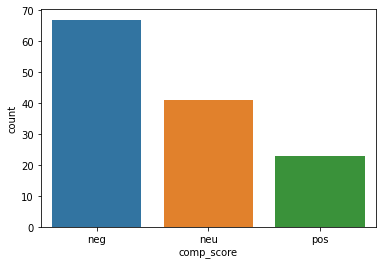

In [308]:
sns.countplot(x="comp_score", data=sentences_df)

<AxesSubplot:xlabel='neg_score'>

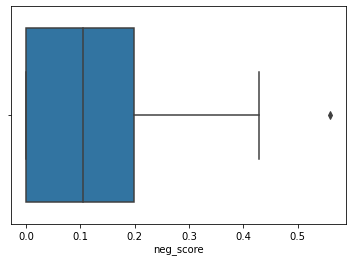

In [315]:
sns.boxplot(x="neg_score", data=sentences_df)

<AxesSubplot:xlabel='neu_score'>

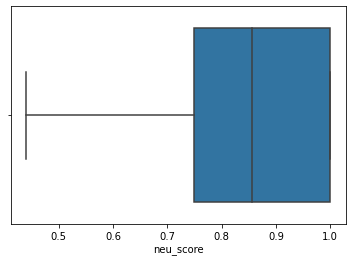

In [316]:
sns.boxplot(x="neu_score", data=sentences_df)

<AxesSubplot:xlabel='pos_score'>

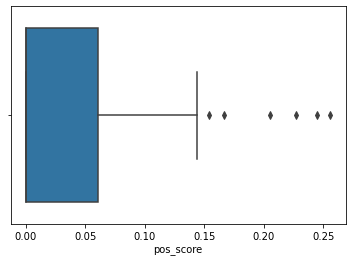

In [317]:
sns.boxplot(x="pos_score", data=sentences_df)

<AxesSubplot:xlabel='compound'>

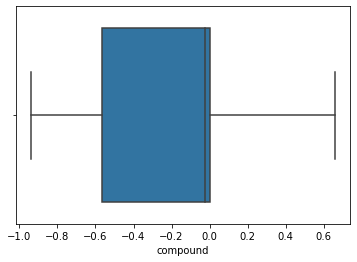

In [314]:
sns.boxplot(x="compound", data=sentences_df)

## Topic Modelling

In [487]:
sentences = extract_sentences(text)
sentencestm_df = pd.DataFrame(sentences, columns = ['sentence'])

sentencestm_df.head(10)

,sentence
0,The suspect in Monday's mass shooting at a Jul...
1,"\n\nIf Robert E. Crimo III , 21, is convicted,..."
2,"More charges are expected to come, Rinehart sa..."
3,"\n\n""These are just the first of many charges ..."
4,"""\n\nCrimo has been in police custody since be..."
5,"\n\n""Tomorrow morning at the Lake County court..."
6,\n\nAttorney Thomas Durkin confirmed to CNN hi...
7,\n\nAttorney Steve Greenberg has been retained...
8,The attorney released a statement on Twitter o...
9,"\n\n""We are all mothers and fathers, sisters a..."


In [488]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [489]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [490]:
dtm = tfidf.fit_transform(sentencestm_df['sentence'])

In [491]:
dtm

<135x261 sparse matrix of type '<class 'numpy.float64'>'
	with 933 stored elements in Compressed Sparse Row format>

In [492]:
from sklearn.decomposition import NMF

In [493]:
nmf_model = NMF(n_components=10,random_state=42)

In [494]:
nmf_model.fit(dtm)

C:\Users\aviko\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=10, random_state=42)

In [495]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['enforcement', 'law', 'revealed', 'immediately', 'believe', 'victims', 'planned', 'terror', 'information', 'weeks', 'monday', 'said', 'covelli', 'investigators', 'shooting']


THE TOP 10 WORDS FOR TOPIC #1
['news', 'state', 'left', 'following', 'mass', 'downtown', 'fourth', 'tuesday', 'shooting', 'illinois', 'scene', 'police', 'july', 'highland', 'park']


THE TOP 10 WORDS FOR TOPIC #2
['car', 'residence', 'seen', 'classmates', 'firearms', 'said', 'music', 'evening', 'awake', 'parents', 'time', 'police', 'covelli', 'authorities', 'crimo']


THE TOP 10 WORDS FOR TOPIC #3
['harris', 'public', 'celebration', 'according', 'thought', 'patients', 'birnberg', 'began', 'fireworks', 'gunfire', 'hospitals', 'age', 'tuesday', 'anthony', 'said']


THE TOP 10 WORDS FOR TOPIC #4
['knew', 'paul', 'years', 'just', 'quiet', 'confirmed', 'attorney', 'broken', 'parade', 'arm', 'medina', 'little', 'told', 'tuesday', 'cnn']


THE TOP 10 WORDS FOR TOPIC #5
['41', 'ran', 'atten

C:\Users\aviko\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [676]:
topic_results = nmf_model.transform(dtm)

In [677]:
sentencestm_df['topic'] = topic_results.argmax(axis=1)

sentencestm_df.head(10)

,sentence,topic
0,The suspect in Monday's mass shooting at a Jul...,1
1,"\n\nIf Robert E. Crimo III , 21, is convicted,...",8
2,"More charges are expected to come, Rinehart sa...",8
3,"\n\n""These are just the first of many charges ...",8
4,"""\n\nCrimo has been in police custody since be...",2
5,"\n\n""Tomorrow morning at the Lake County court...",8
6,\n\nAttorney Thomas Durkin confirmed to CNN hi...,4
7,\n\nAttorney Steve Greenberg has been retained...,4
8,The attorney released a statement on Twitter o...,4
9,"\n\n""We are all mothers and fathers, sisters a...",8


## Attempting Text Generation

In [604]:
import spacy
nlp = spacy.load('en_core_web_sm')

nlp.max_length = 1198623

In [605]:
def separate_punc(text):
    return [token.text.lower() for token in nlp(text) if token.text not in '\n\n \n\n\n!"-#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~\t\n ']

In [606]:
tokens = separate_punc(text)

In [607]:
tokens[0:50]

['the',
 'suspect',
 'in',
 'monday',
 "'s",
 'mass',
 'shooting',
 'at',
 'a',
 'july',
 '4th',
 'parade',
 'in',
 'highland',
 'park',
 'illinois',
 'that',
 'left',
 'seven',
 'dead',
 'and',
 'injured',
 'more',
 'than',
 'two',
 'dozen',
 'has',
 'been',
 'charged',
 'with',
 'seven',
 'counts',
 'of',
 'first',
 'degree',
 'murder',
 'lake',
 'county',
 'state',
 "'s",
 'attorney',
 'eric',
 'rinehart',
 'announced',
 'during',
 'a',
 'news',
 'conference',
 'tuesday',
 'evening']

In [608]:
len(tokens)

2894

In [609]:
train_len = 25+1

text_sequences = []

for i in range(train_len, len(tokens)):
    
    seq = tokens[i-train_len:i]
    
    text_sequences.append(seq)

In [610]:
' '.join(text_sequences[0])

"the suspect in monday 's mass shooting at a july 4th parade in highland park illinois that left seven dead and injured more than two dozen"

In [611]:
' '.join(text_sequences[1])

"suspect in monday 's mass shooting at a july 4th parade in highland park illinois that left seven dead and injured more than two dozen has"

In [612]:
len(text_sequences)

2868

In [613]:
from keras.preprocessing.text import Tokenizer

In [614]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences)

In [615]:
sequences[0]

[1,
 57,
 6,
 31,
 9,
 47,
 18,
 25,
 2,
 98,
 992,
 39,
 6,
 17,
 16,
 63,
 21,
 97,
 137,
 989,
 3,
 136,
 41,
 96,
 208,
 393]

In [616]:
#tokenizer.index_word

In [617]:
for i in sequences[0]:
    print(f'{i} : {tokenizer.index_word[i]}')

1 : the
57 : suspect
6 : in
31 : monday
9 : 's
47 : mass
18 : shooting
25 : at
2 : a
98 : july
992 : 4th
39 : parade
6 : in
17 : highland
16 : park
63 : illinois
21 : that
97 : left
137 : seven
989 : dead
3 : and
136 : injured
41 : more
96 : than
208 : two
393 : dozen


In [618]:
#tokenizer.word_counts

In [623]:
vocabulary_size = len(tokenizer.word_counts)
vocabulary_size

995

In [624]:
sequences = np.array(sequences)

In [625]:
sequences

array([[  1,  57,   6, ...,  96, 208, 393],
       [ 57,   6,  31, ..., 208, 393,  48],
       [  6,  31,   9, ..., 393,  48,  72],
       ...,
       [ 21,  44, 142, ..., 995,  19,   2],
       [ 44, 142, 209, ...,  19,   2, 210],
       [142, 209,  25, ...,   2, 210,  22]])

In [626]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding

In [627]:
def create_model(vocabulary_size, seq_len):
    model = Sequential()
    model.add(Embedding(vocabulary_size, 25, input_length=seq_len))
    model.add(LSTM(150, return_sequences=True))
    model.add(LSTM(150))
    model.add(Dense(150, activation='relu'))

    model.add(Dense(vocabulary_size, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    model.summary()
    
    return model

In [628]:
from keras.utils import to_categorical

In [629]:
X = sequences[:,:-1]

In [630]:
y = sequences[:,-1]

In [631]:
y = to_categorical(y, num_classes=vocabulary_size+1)

In [632]:
seq_len = X.shape[1]

In [633]:
seq_len

25

In [634]:
model = create_model(vocabulary_size+1, seq_len)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 25, 25)            24900     
                                                                 
 lstm_10 (LSTM)              (None, 25, 150)           105600    
                                                                 
 lstm_11 (LSTM)              (None, 150)               180600    
                                                                 
 dense_10 (Dense)            (None, 150)               22650     
                                                                 
 dense_11 (Dense)            (None, 996)               150396    
                                                                 
Total params: 484,146
Trainable params: 484,146
Non-trainable params: 0
_________________________________________________________________


In [635]:
from pickle import dump,load

In [636]:
model.fit(X, y, batch_size=128, epochs=300,verbose=1)

Epoch 1/300
23/23 [==============================] - 6s 94ms/step - loss: 6.6617 - accuracy: 0.0481
Epoch 2/300
23/23 [==============================] - 2s 94ms/step - loss: 6.1317 - accuracy: 0.0523
Epoch 3/300
23/23 [==============================] - 2s 97ms/step - loss: 6.0552 - accuracy: 0.0523
Epoch 4/300
23/23 [==============================] - 2s 95ms/step - loss: 6.0303 - accuracy: 0.0523
Epoch 5/300
23/23 [==============================] - 2s 94ms/step - loss: 6.0223 - accuracy: 0.0523
Epoch 6/300
23/23 [==============================] - 2s 94ms/step - loss: 6.0174 - accuracy: 0.0523
Epoch 7/300
23/23 [==============================] - 2s 95ms/step - loss: 6.0190 - accuracy: 0.0523
Epoch 8/300
23/23 [==============================] - 2s 94ms/step - loss: 6.0127 - accuracy: 0.0523
Epoch 9/300
23/23 [==============================] - 2s 94ms/step - loss: 6.0075 - accuracy: 0.0523
Epoch 10/300
23/23 [==============================] - 2s 93ms/step - loss: 5.9893 - accuracy: 0.0523

In [637]:
model.save('cnn_model.h5')
dump(tokenizer, open('cnn_tokenizer', 'wb'))

In [652]:
from random import randint
from pickle import load
from keras.models import load_model
from keras_preprocessing.sequence import pad_sequences

In [660]:
def generate_text(model, tokenizer, seq_len, seed_text, num_gen_words):
    
    output_text = []
    
    input_text = seed_text
    
    for i in range(num_gen_words):
        
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
        
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
        
        pred_word_ind = np.argmax(model.predict(pad_encoded,verbose=0)[0])
        
        pred_word = tokenizer.index_word[pred_word_ind] 
        
        input_text += ' ' + pred_word
        
        output_text.append(pred_word)
        
    return ' '.join(output_text)

In [661]:
text_sequences[0]

['the',
 'suspect',
 'in',
 'monday',
 "'s",
 'mass',
 'shooting',
 'at',
 'a',
 'july',
 '4th',
 'parade',
 'in',
 'highland',
 'park',
 'illinois',
 'that',
 'left',
 'seven',
 'dead',
 'and',
 'injured',
 'more',
 'than',
 'two',
 'dozen']

In [666]:
import random
random.seed(50)
random_pick = random.randint(0,len(text_sequences))

In [667]:
random_seed_text = text_sequences[random_pick]
random_seed_text

['out',
 'of',
 'highland',
 'park',
 'high',
 'in',
 '2017',
 'he',
 'splattered',
 'awake',
 'stickers',
 'in',
 'the',
 'school',
 "'s",
 'stairways',
 'and',
 'bathrooms',
 'the',
 'former',
 'classmate',
 'said',
 'crimo',
 'made',
 'music',
 'under']

In [668]:
seed_text = ' '.join(random_seed_text)
seed_text

"out of highland park high in 2017 he splattered awake stickers in the school 's stairways and bathrooms the former classmate said crimo made music under"

In [669]:
generate_text(model,tokenizer,seq_len,seed_text=seed_text,num_gen_words=50)

'the name awake the rapper on monday covelli said law enforcement officials processed a significant amount of digital evidence which helped investigators identify crimo as the suspect crimo posted online music videos on several major streaming outlets and on a personal website with some featuring animated scenes of gun violence'